In [1]:
# Standardopsætning (kør denne først)
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42) # YEAH 42

# Dansk labels i figurer
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# SCG og mekaniske hændelser: Filtering og feature-timing

**Udover moving average:** Butterworth (zero-phase), Medianfiltrering  
Fokus: 
- korrekt glatning uden tidsforskydning
- envelopes
- peak-detektion


# Goal for today's Lecture

- Forstå Hvad et PCG er
- Forstå frekvens indhold af et signal
- Viden omkring filtrering af signaler
- Evne til at indentificerer og udtrække S1 og S2 lyde fra et signal. (Lub Dub)

## Data Workflow

```mermaid
flowchart LR
    A[Load Data] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

### Exercise: Load data i et program
**Du ved:**
- Hvordan man loader data fra en fil ind i hukommelsen
- Hvordan man loader flere kolonner fra en fil
- Hvordan man visualiserer data
- Hvordan man laver titel, x- og y- labels, etc. på en figur

**Du skal nu**
1. loade alle kolonnerne `timestamp`, `ecg`, `pcg` fra filen `files/ECGPCG.csv` til hver deres variabel af samme navn.
2. Visualiserer `pcg`, og `ekg`. 

*Hint: Den første linje er kolonne navne, læs om hvordan man skipper en kolonne her: **[np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)***

### Answer
Den naive løsning er at man bare plotter det hele i et enkelt plt. 

Lad os gøre det.

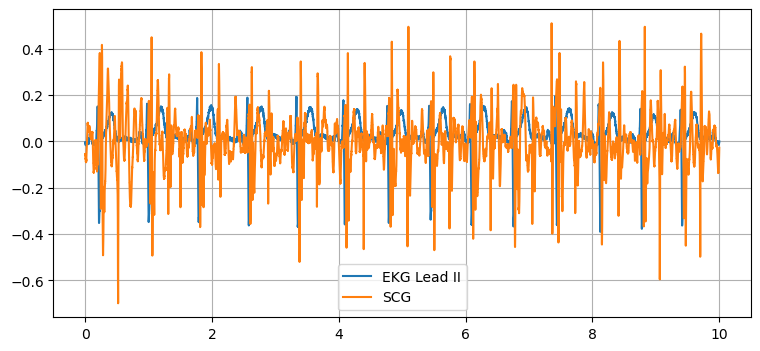

In [2]:
import numpy as np
import matplotlib.pyplot as plt
filename = "files/ECGPCG.csv"
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

plt.plot(timestamp, ecg, label="EKG Lead II")
plt.plot(timestamp, pcg, label="SCG")
plt.legend()
plt.show()


## Subplots giver overblik

* Adskiller signaler og reducerer visuel støj
* Muliggør direkte sammenligning via fælles tidsakse
* Tillader korrekt skalering af hvert signal
* Forbedrer læsbarhed og fortolkning


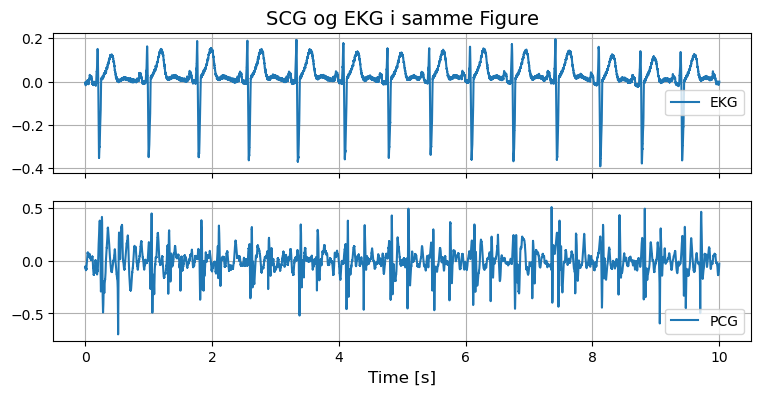

In [3]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(timestamp, ecg, label="EKG")
axs[0].legend()
axs[1].plot(timestamp, pcg, label="PCG")
axs[1].legend()
axs[1].set_xlabel("Time [s]")
axs[0].set_title("SCG og EKG i samme Figure")
plt.show()

## Clean Data

```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[**Clean**]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

# Exercise: moving average (mov)?

* mov er simpelt, men har **bølget amplitude-respons** (ripple) og kan **udvaske skarpe events**
* Ved timing af AO/AC kræves **minimal fasefejl**

**Bedre valg i praksis:**
* **Butterworth + `filtfilt`** → zero-phase lavpas uden tidsforskydning
* **Medianfilter** → robust mod outliers og impulsartefakter
* **Moving average** → hurtig støjreduktion, men **ikke egnet til præcis timing**

**Opgave:**
1. Hver især (altså ikke flere på samme PC); I programmet `files/adjust_mov_practice.py` ændre `window` til en størrelse så DU mener at signalet er godt, hvis man skal se S1 og S2.
2. Snak med hinanden:
    - Argumenter for dit `window` valg, og hvorfor det er bedre! (I skal ikke ændre jeres valg)
    - Hvad ved I ved omkring pcg signalet.
    - Fjerner moving average højfrekvens eller lavfrekvens støj?
    - Giver et moving average filter mening?

## Svar
- Der er ikke noget godt svar for en window size.
    - Dette er fordi S1 og S2 signalerne bl.a. indeholder meget **lavfrekens** støj.
- Data er gemt med 8000Hz.
- Men hvorfor siger jeg det?

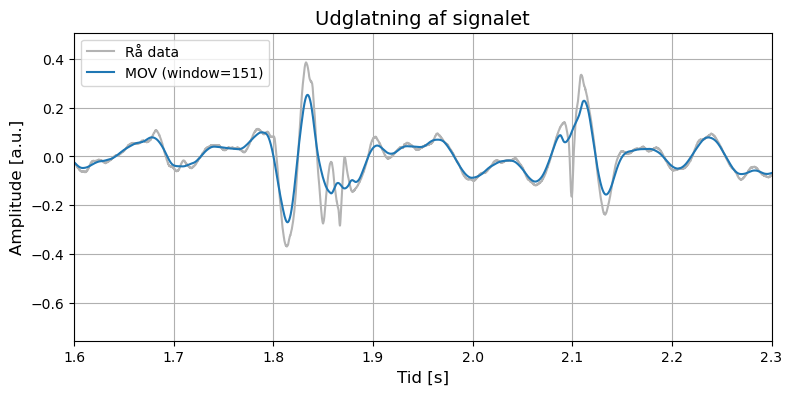

In [6]:
# %load files/adjust_mov_practice.py
# Moving average (for reference)
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt, medfilt
import numpy as np
import matplotlib.pyplot as plt

# Juster window 
window = 151
filename = "files/ECGPCG.csv" # Hvis du får en FileNotFoundError, prøv at fjern "files/" fra string.
fc = 50  # cutoff Hz



"""
Lad være med at ændre noget herunder. 
OGSÅ selvom i får en error.
(det gør i bl.a. hvis window er et lige tal)
"""
fs = 8000 # sample rate Hz

# HEY LOOK; Du kan også bare loade specifikke columns! (der er 5 columns i filen)
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)


x = pcg[:fs*4] # 4 sekunder af SCG signalet
t = timestamp[:fs*4] 

# moving average filter (du kan lave et MOV på MANGE måder)
x_ma = uniform_filter1d(x,window)

plt.figure()
plt.plot(t, x, color='0.7', label='Rå data')
plt.plot(t, x_ma, label=f'MOV ({window=})')
plt.title('Udglatning af signalet')
plt.xlabel('Tid [s]')
plt.ylabel('Amplitude [a.u.]')
plt.xlim([1.6, 2.3])
plt.legend()
plt.show()

# Know Your Data!!!
```mermaid
flowchart LR
    A[Load Data] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```
- Hvad er et PCG signal egentlig?
- Det er et stetoskop.
- $20Hz < \textbf{det menneskelige auditive spektrum} < 20 000 Hz$



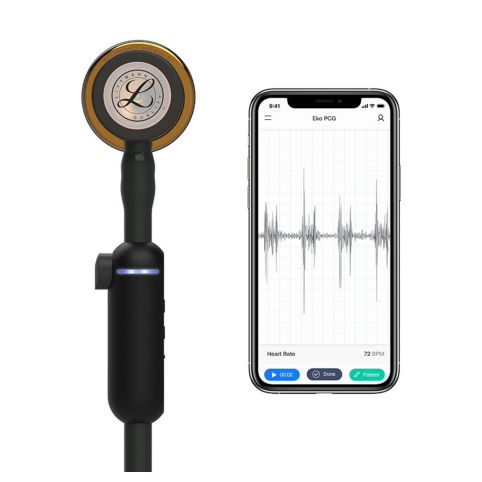

In [103]:
plt.figure(figsize=(8,6))
plt.imshow(plt.imread("files/stetoskop.jpg"))
plt.axis('off')               # hides axes and ticks
plt.show()

For at spille en lydfil gennem python (Ikke Jupyter!), kan man bruge pakken `sounddevice`,
herefter kan man fx køre programmet `files/play_sound.py`

>```python 
>import sounddevice as sd
>from scipy.signal import resample
>import numpy as np
>filename = "files/b001.csv"
>data = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True, usecols=[3])
>fs = 5000 # orginal sampling frekvens
># sounddevice kan ikke finde ud af 5000Hz, så vi konverterer det om (resampler) til 44100Hz
>fs_new = 44100 # Normal 
>num_samples = int(len(data) * fs_new / fs)
>data_resampled = resample(data, num_samples)
>sd.play(data_resampled, fs_new)
>sd.wait()           # Wait until playback finishes
>```



In [104]:
from IPython.display import Audio
Audio(pcg, rate=fs,normalize=True)

# Hvor kommer S₁ og S₂ fra?

### S₁ – *første hjertelyd*

* Opstår når **mitralklappen og trikuspidalklappen lukker**
* Marker starten på **systolen** (hjertets pumpefase)
* Ofte beskrevet som **“lub”**
* Har typisk **lavere frekvens** og lidt længere varighed

### S₂ – *anden hjertelyd*

* Opstår når **aortaklappen og pulmonalklappen lukker**
* Marker slutningen af systolen / starten på **diastolen**
* Ofte beskrevet som **“dub”**
* Typisk **kortere og lidt højere frekvens** end S₁

# I et stetoskop-signal

Når du måler med et stetoskop, er dit rå signal en blanding af:

* S₁ og S₂ (de dominerende lyde)
* Eventuelle ekstra hjertelyde (S₃, S₄)
* Støj fra vejrtrækning og omgivelser

Her er **envelopen** super nyttig, fordi den:

* Følger signalets **energi / amplitude**
* Gør det meget lettere at **se og detektere S₁ og S₂ som peaks**
* Ofte bruges som første trin i **automatisk hjertelydsanalyse**

**S₁ og S₂ kommer fra klaplukninger i hjertet, og envelopen hjælper dig med at finde dem i signalet.**


# Clean

```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[**Clean**]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

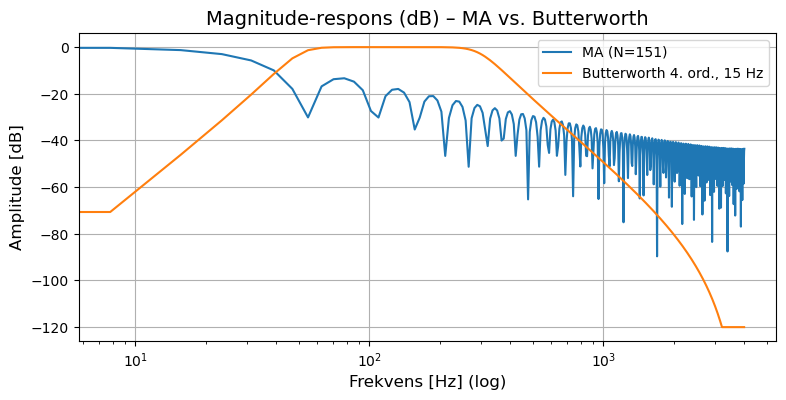

In [10]:
# Frekvensrespons (intuitiv sammenligning)

from scipy.signal import butter, freqz
fs=8000
w_ma = np.ones(window)/window
# MA frekvensrespons via FFT af kernel
W = np.fft.rfft(w_ma, 1024)
f = np.fft.rfftfreq(1024, d=1/fs)
fc = [50,300]
b, a = butter(4, fc, fs=fs, btype='bandpass') 
w, H = freqz(b, a, fs=fs)

plt.semilogx(f, 20*np.log10(np.maximum(np.abs(W), 1e-6)), label='MA (N=%d)'%window)
plt.semilogx(w, 20*np.log10(np.maximum(np.abs(H), 1e-6)), label='Butterworth 4. ord., 15 Hz')
plt.title('Magnitude-respons (dB) – MA vs. Butterworth')
plt.xlabel('Frekvens [Hz] (log)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()


# Valg af cut-off via spektral information (Spektral / Frekvens Spektret)


```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[**Visualize**]
    D --> E[Extract Features]
    E --> F[Store]
```

**Sådan finder man LUB DUB**
- Brug **Welch‑PSD** til at se hvor energien ligger.  
- Sæt lavpas hvor du mener hovedindholdet af hjertelydene er for at fjerne lav frekvens støj, men bevare events.


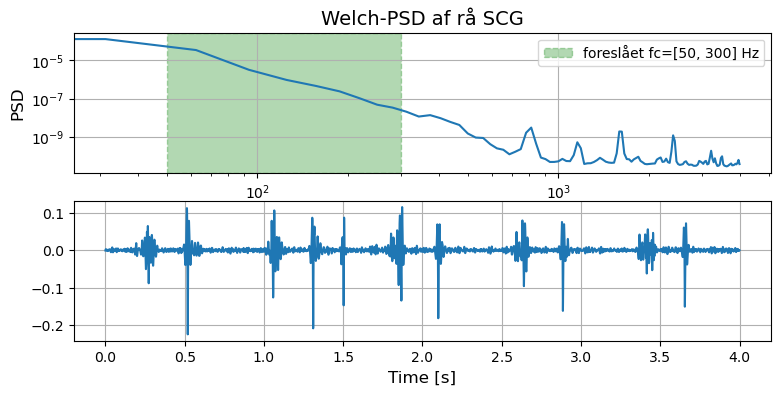

In [14]:
# Welch-PSD for at motivere cut-off

from scipy.signal import welch
f, Pxx = welch(x, fs=fs)

# Butterworth zero-phase
b, a = butter(4, fc, fs=fs, btype='bandpass') # type: ignore
lubdub = filtfilt(b, a, x)
t_lubdub = np.linspace(0,len(lubdub)/fs, len(lubdub))
# Visualize
fig,axs = plt.subplots(2,1)
axs[0].semilogy(f, Pxx)
axs[0].axvspan(xmin=fc[0],xmax=fc[1], color='green', linestyle='--', label=f'foreslået fc={[50,300]} Hz', alpha=0.3)
axs[0].set_title('Welch-PSD af rå SCG')
axs[0].set_xlabel('Frekvens [Hz]')
axs[0].set_xscale("log")
axs[0].set_ylabel('PSD')
axs[0].legend()
axs[1].plot(t_lubdub,lubdub)
#axs[1].set_title('Filtered Signal')
axs[1].set_xlabel('Time [s]')


plt.show()

In [13]:

from IPython.display import Audio
Audio(lubdub, rate=fs,normalize=True)

# Detektion af S1 og S2
```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[**Extract Features**]
    E --> F[Store]
```


## Overblik: idéen bag S₁ / S₂-detektion

![Image](files/S1S2_1.jpg)
![Image](files/S1S2_2.jpg)


1. Beregn envelopen af stetoskop-signalet
2. Find **lokale maxima (peaks)** i envelopen
3. Brug **tidsafstande mellem peaks** til at skelne S₁ og S₂

## Det vigtige fysiologiske trick 🧠

I én hjertesyklus gælder typisk:

* **S₁ → S₂** : *kort interval* (systole)
* **S₂ → næste S₁** : *længere interval* (diastole)

👉 Det betyder:

> **S₁ er den peak, der kommer efter den længste pause**

# **The Envelope**

### Hvad er en envelope?

En **envelope** er et “tæppe” lagt over et signal, som fremhæver dets overordnede form og hjælper med at tydeliggøre vigtige elementer.
Eksempel: Stetoskop-signaler med **S₁** og **S₂** hjertelyde.

---

### Hvorfor bruge en envelope?

* Fremhæver signalets amplitudeændringer
* Gør mønstre lettere at se
* Hjælper med analyse af komplekse signaler

---

### Simpel metode til at beregne en envelope

1. **Definer signal `s` og `window`**

2. **Fjern gennemsnittet**
   $$
   s_0 = s - \text{Mean}(s)
   $$
3. **Rectify signalet**
   Tag den absolutte værdi:
   $$
   r = |s_0|
   $$
4. **Beregn lokal maksimum (Moving Maximum)** i et `window` omkring hvert element i `r`:
5. **Tilføj gennemsnittet til mov_max**
   $$
   e = mov\_max + \text{Mean}(s)
   $$
   `e` er nu **envelopen**, klar til visualisering.



**Tip:** Visualiser signalet sammen med envelopen for at se, hvordan den fremhæver amplitudeændringer.


(2.5, 4.0)

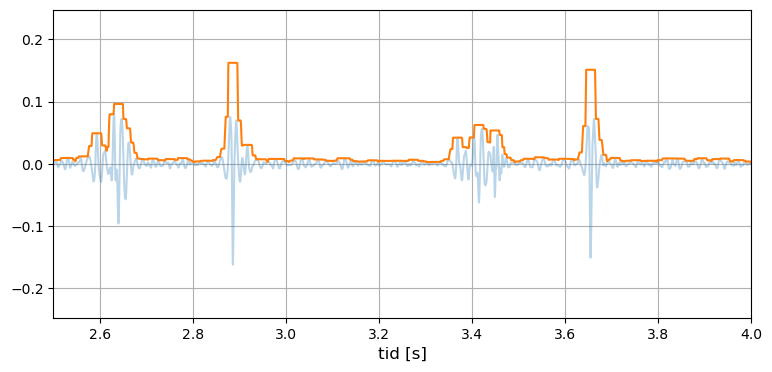

In [17]:
import numpy as np

def envelope(x, window=50):
    """
    Beregn en envelope for et signal x.
    """
    # 1. Fjern gennemsnittet
    mean_x = np.mean(x)
    s0 = x - mean_x

    # 2. Rectify (absolut værdi)
    r = np.abs(s0)

    # 3. Moving Maximum
    mov_max = np.zeros_like(r)
    half_w = window // 2
    for i in range(len(r)):
        start = max(i - half_w, 0)
        end = min(i + half_w + 1, len(r))
        mov_max[i] = np.max(r[start:end])

    # 4. Tilføj gennemsnittet tilbage
    env = mov_max + mean_x
    return env

e = envelope(lubdub,window=150)
plt.plot(t_lubdub,lubdub, label="lubdub", alpha=0.3)
plt.plot(t_lubdub,e, label="envelope")
plt.xlabel("tid [s]")
plt.xlim([2.5, 4])





## Trin-for-trin metode

### Find peaks i envelopen



Find peaks:

```python
from scipy.signal import find_peaks

peaks, _ = find_peaks(env, distance=200)  # distance afhænger af fs
```

### Beregn tidsafstand mellem peaks

```python
intervals = np.diff(peaks)
```

Store intervaller ≈ **diastole**
Små intervaller ≈ **systole**


### Klassificér S₁ og S₂
For at klassificerer, skal vi lave en regl.

En enkel og robust tommelfingerregel er at tiden mellem S1 til S2 er mindre end tiden mellem S2 til S1:
Tænk: Lup-Dup----Lup-Dup----Lup-Dup...

```python
S1 = []
S2 = []

for i in range(1, len(peaks) - 1):
    if intervals[i-1] > intervals[i]:
        S1.append(peaks[i])
    else:
        S2.append(peaks[i])
```

👉 Peak efter **lang pause** → **S₁**
👉 Peak efter **kort pause** → **S₂**

---


## Histogram – hvornår er det stærkt?
- Viser **fordeling** (fx intervaller).  
- Godt til at kommunikere **variabilitet** og **outliers**.  
- Relater til **middelværdi** (μ) og **standardafvigelse** (σ).  
- Vælg binstørrelse fornuftigt.

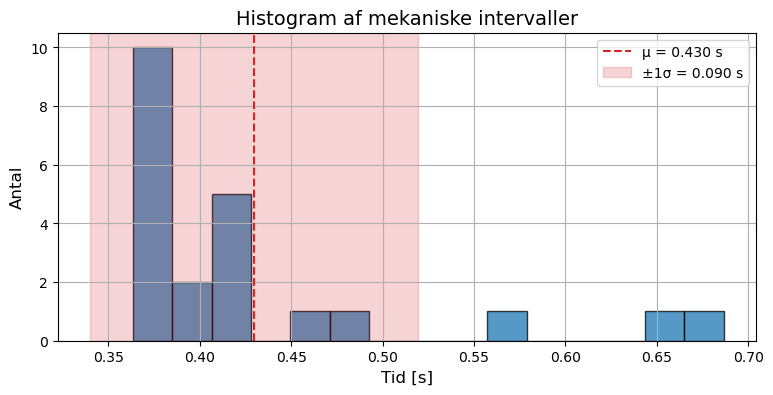

In [32]:
# Histogram af peak-til-peak intervaller
from scipy.signal import find_peaks
y = pcg
pks, _ = find_peaks(y, prominence=np.std(y)*0.8, distance=int(0.35*fs))
intervals = np.diff(pks)/fs
mu = np.mean(intervals)
sd = np.std(intervals)
plt.figure(); 
plt.hist(intervals, bins=15, edgecolor='k', alpha=0.75)
plt.axvline(mu, color='C3', linestyle='--', label=f'μ = {mu:.3f} s')
plt.axvspan(mu-sd, mu+sd, color='C3', alpha=0.2, label=f'±1σ = {sd:.3f} s')
plt.title('Histogram af mekaniske intervaller'); 
plt.xlabel('Tid [s]'); 
plt.ylabel('Antal');
plt.legend();
plt.show()


# Bruge Histogram til at finde for- og bagrunds støj

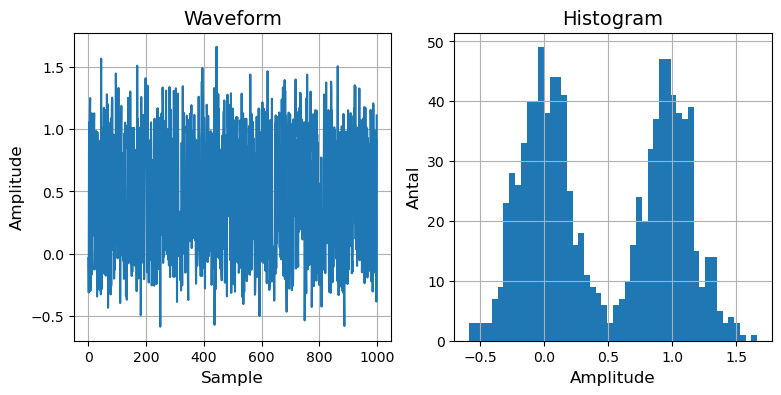

In [33]:
d = np.loadtxt("files/random_dist.csv")

fig, axs = plt.subplots(1,2)
axs[0].plot(d)
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Waveform")
axs[1].hist(d,   bins=50)
axs[1].set_xlabel("Amplitude")
axs[1].set_ylabel("Antal")
axs[1].set_title("Histogram")
plt.show()


# Øvelsessession (2–3 timer)

Fokus: **zero‑phase filtrering**, **peak‑detektion** og **R→AO timing**.

## Filtrering uden tidsforskydning
**1. Scene og mål:** Et SCG‑signal skal glattes uden at forskyde AO‑tidspunkterne.  
**2. Hvad I ved/skal bruge/udbytte:** `butter` + `filtfilt`, `savgol_filter`, evt. `medfilt`. Forstå trade‑offs i form/bevaring af peaks.  
**3. Opgave:** Design to filtre (Butterworth + Savitzky–Golay), anvend på SCG, **kvantificér** evt. tidsforskydning ved at sammenligne top‑tidspunkter før/efter og **argumentér** for jeres valg.

In [8]:
# Svarskitse – filtrering uden lag

from scipy.signal import butter, filtfilt

fs = 200; T = 10.0
t = np.arange(0, T, 1/fs)
scg = 0.5*np.sin(2*np.pi*1.1*t) + 0.35*np.random.randn(len(t))
for tt in np.arange(0.6, T, 1.0):
    i = int(tt*fs)
    if i+3 < len(scg): scg[i:i+3] += [0.9, 1.2, 0.6]

b, a = butter(4, 15/(fs/2))
y_bw = filtfilt(b, a, scg)

# Sammenlign toppe i et vindue
s, e = int(2.0*fs), int(3.5*fs)
i_raw = s + np.argmax(scg[s:e])
i_bw  = s + np.argmax(y_bw[s:e])
i_sg  = s + np.argmax(y_sg[s:e])

plt.figure();
plt.plot(t[s:e], scg[s:e], color='0.7', label='Rå')
plt.plot(t[s:e], y_bw[s:e], label='Butterworth (filtfilt)')
plt.axvline(t[i_raw], color='k', linestyle=':', label='Top rå')
plt.axvline(t[i_bw], color='C0', linestyle='--', label='Top BW')
plt.axvline(t[i_sg], color='C1', linestyle='--', label='Top SG')
plt.title('Top‑timing i vindue – sammenligning')
plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

print('Δt BW vs. rå: %.1f ms' % ((t[i_bw]-t[i_raw])*1e3))

NameError: name 'y_sg' is not defined

## Peak‑detektion med prominence
**1. Scene og mål:** Identificér mekaniske beats robust i tilstedeværelse af støj.  
**2. Værktøjer/udbytte:** `find_peaks` med **prominence**, **distance**; forstå forskellen på højde og prominence.  
**3. Opgave:** Vælg parametre, detektér peaks, beregn gennemsnitligt mekanisk interval og visualisér et histogram med μ og ±1σ.

In [ ]:
# Svarskitse – robust peak-detektion

from scipy.signal import find_peaks, butter, filtfilt
# Brug tidligere filtrerede y_bw hvis tilgængelig, ellers lav den nu
if 'y_bw' not in globals():
    b, a = butter(4, 15/(fs/2))
    y_bw = filtfilt(b, a, scg)
prom = 0.8*np.std(y_bw)
peaks, props = find_peaks(y_bw, prominence=prom, distance=int(0.35*fs))

intervals = np.diff(peaks)/fs
mu = np.mean(intervals) if len(intervals) else np.nan
sd = np.std(intervals, ddof=1) if len(intervals)>1 else 0.0

plt.figure(); plt.plot(t, y_bw, label='Filtreret (BW)')
plt.plot(t[peaks], y_bw[peaks], 'rx', label='Peaks')
plt.title('Peaks med prominence'); plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

if len(intervals) > 0:
    plt.figure(); plt.hist(intervals, bins=10, edgecolor='k', alpha=0.75)
    if np.isfinite(mu):
        plt.axvline(mu, color='C3', linestyle='--', label=f'μ = {mu:.3f} s')
        plt.axvspan(mu-sd, mu+sd, color='C3', alpha=0.2, label=f'±1σ = {sd:.3f} s')
    plt.title('Histogram af mekaniske intervaller'); plt.xlabel('Tid [s]'); plt.ylabel('Antal'); plt.legend(); plt.tight_layout(); plt.show()


## Synkronisering: R→AO timing
**1. Scene og mål:** Relatér R‑peaks (ECG) til AO i SCG og estimer mekanisk forsinkelse.  
**2. Værktøjer/udbytte:** `numpy`, `find_peaks`, simple vinduer efter R.  
**3. Opgave:** For hver R: søg AO i [60, 200] ms, beregn R→AO for alle slag, og fortolk fordelingen.

In [ ]:
# Svarskitse – R→AO timing

from scipy.signal import find_peaks
tmp_peaks, _ = find_peaks(y_bw, prominence=0.8*np.std(y_bw), distance=int(0.5*fs))
r_peaks = (tmp_peaks - int(0.1*fs))
r_peaks = r_peaks[r_peaks>0]

r2ao = []
ao_idx = []
for rp in r_peaks:
    s = rp + int(0.06*fs)
    e = min(rp + int(0.20*fs), len(y_bw))
    seg = y_bw[s:e]
    if len(seg)==0: continue
    ao = s + np.argmax(seg)
    ao_idx.append(ao); r2ao.append((ao-rp)/fs)

r2ao = np.array(r2ao)

plt.figure();
sel = slice(0, min(len(t), int(4*fs)))
plt.plot(t[sel], y_bw[sel], label='SCG (BW)')
plt.plot(t[r_peaks], y_bw[r_peaks], 'k|', markersize=10, label='R-peaks')
plt.plot(t[ao_idx], y_bw[ao_idx], 'ro', label='AO')
plt.title('Synkronisering: R og AO'); plt.xlabel('Tid [s]'); plt.ylabel('Amp.'); plt.legend(); plt.tight_layout(); plt.show()

if len(r2ao)>0:
    mu, sd = np.mean(r2ao), np.std(r2ao, ddof=1) if len(r2ao)>1 else 0.0
    plt.figure(); plt.hist(r2ao*1e3, bins=10, edgecolor='k', alpha=0.75)
    plt.axvline(mu*1e3, color='C3', linestyle='--', label=f'μ = {mu*1e3:.1f} ms')
    plt.axvspan((mu-sd)*1e3, (mu+sd)*1e3, color='C3', alpha=0.2, label=f'±1σ = {sd*1e3:.1f} ms')
    plt.title('Histogram af R→AO'); plt.xlabel('Tid [ms]'); plt.ylabel('Antal'); plt.legend(); plt.tight_layout(); plt.show()


## Takeaways
- Brug **zero‑phase** (f.eks. `filtfilt`) når timing er kritisk.  
- **Savitzky–Golay** kan bevare peak‑form bedre end MA.  
- **Median** hjælper mod outliers.  
- Understøt valg af cut‑off med simple **PSD‑plots**.  
- Formidl variabilitet med **histogrammer** (μ og σ).